In [92]:
from pathlib import Path
import time
from itertools import product

import cv2
import h5py
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter, rotate

import torch
from tqdm.auto import tqdm

import sklearn.cluster as skc
import sklearn.metrics as skm
from torch_dct import dct_2d
from scipy.ndimage import zoom
import scipy.signal as sps

from sklearn import metrics
from scipy import stats

import arpesnet as an
from arpesnet import transform as tr
# import knano.transform as tr
# import neuralarpes as na
# from neuralarpes import transform as tr

# import dataloader as dl




# fix random number generator

In [93]:
seed = 192
rng = np.random.default_rng(seed)

In [94]:
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

# Load Dataset

In [280]:
# filename = "Cleave3_14.h5"        # 2,92 Gb   -   Egern
filename = "GPScan_5.h5"          # 0,66 Gb   -   Papua
# filename = "GPScan_133_1.h5"      # 3,96 Gb   -   Nazgûl
# filename = "gr_flake_full.h5"     # 0,49 Gb   -   Das Brot
# filename = "gr_flake_256.h5"      # 0,44 Gb

# filename = "misfit_Se3d_512.h5"   # 0, Gb
# filename = "misfit_Se3d_1024.h5"   # 0, Gb
# filename = "misfit_Se3d_full.h5"  # 0, Gb
# filename = "misfit_Bi5d_512.h5"   # 0, Gb
# filename = "misfit_Bi5d_1024.h5"   # 0, Gb
# filename = "misfit_Bi5d_full.h5"  # 0, Gb
# filename = "misfit_VB_512.h5"   # 0, Gb
# filename = "misfit_VB_1024.h5"   # 0, Gb
# filename = "misfit_VB_full.h5"  # 0, Gb


DATA_DIR = Path(os.path.dirname(os.getcwd())) / "Main Data" / filename
#Open the H5 file in read mode
with h5py.File(DATA_DIR, 'r') as file:
    h5_tree(file)
    
    if(filename in ["GPScan_133_1.h5", "GPScan_5.h5", "Cleave3_14.h5"]):
        print(file["Entry"]["Data"]["ScanDetails"]["Dim1_name"])
        det = list(file["Entry"]["Data"]["ScanDetails"])
        for d in det:
            try:
                ele = list(file["Entry"]["Data"]["ScanDetails"][d])
                print(f"{d}: {ele}")
            except:
                pass
        pos = np.array(list(file["Entry"]["Data"]["ScanDetails"]["TruePositions"]))
        xer = np.copy(pos[:, 1])
        yer = np.copy(pos[:, 0])

        xer -= np.min(xer)
        yer -= np.min(yer)

        steps = list(file["Entry"]["Data"]["ScanDetails"]["SlowAxis_step"])
        xer /= abs(steps[0])
        yer /= abs(steps[1])


        data = np.array(list(file["Entry"]["Data"]["TransformedData"]))

        axisData = {
            "dims": (int(max(xer))+1, int(max(yer))+1, data.shape[1], data.shape[2]),
            "coords": np.array(list(zip(xer, yer))).astype(int),
            "ori_coords": pos
            # "axis_names": 
            # "x2": 
            # "y2": 
        }

    elif(filename in ["gr_flake_256.h5", "gr_flake_full.h5", "misfit_Se3d_512.h5", "misfit_Se3d_full.h5", "misfit_Bi5d_full.h5", "misfit_Bi5d_512.h5", "misfit_VB_512.h5", "misfit_VB_full.h5"]):
        det = list(file["coords"])
        for d in det:
            try:
                ele = list(file["coords"][d])
                print(f"{d}: {ele}")
            except:
                pass
        # print(file["coords"]["angle"])
        print(list(file["dims"]))
        groupKeys = list(file.keys())
        axisNames = list(file[groupKeys[0]])
        dataCoords = [list(file[groupKeys[0]][axisNames[2]]), list(file[groupKeys[0]][axisNames[3]])]
        data = np.array(list(file[groupKeys[1]]))
        dataShape = data.shape
        data = np.reshape(data, (dataShape[0]*dataShape[1], dataShape[2], dataShape[3]))

        axisData = {
            "dims": dataShape,
            "coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "ori_coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "axis_names": axisNames
        }

    else:
        print("\nNo method defined for this file")

# print()
# print(filename)
# data = np.array(data)
# if(len(data.flatten()) > 20): print(f"data shape = {data.shape}")
# else: print(f"{data=}")


# print(f"dim = {axisData['dims']}")


dimension_labels = ["x", "y", "e", "k"]
dimension_sizes = (axisData["dims"][0], axisData["dims"][1], 256, 256)



└── Entry
    ├── Data
    │   ├── Command (scalar)
    │   ├── ScanDetails
    │   │   ├── Dim1_length (scalar)
    │   │   ├── Dim1_name (scalar)
    │   │   ├── Dim1_start (scalar)
    │   │   ├── Dim1_step (scalar)
    │   │   ├── Dim2_length (scalar)
    │   │   ├── Dim2_name (scalar)
    │   │   ├── Dim2_start (scalar)
    │   │   ├── Dim2_step (scalar)
    │   │   ├── Dimensions (scalar)
    │   │   ├── FastAxis_length (2)
    │   │   ├── FastAxis_names (2)
    │   │   ├── FastAxis_start (2)
    │   │   ├── FastAxis_step (2)
    │   │   ├── SetPositions (5229)
    │   │   ├── SlowAxis_length (2)
    │   │   ├── SlowAxis_names (2)
    │   │   ├── SlowAxis_start (2)
    │   │   ├── SlowAxis_step (2)
    │   │   └── TruePositions (5229)
    │   ├── Timestamp (5229)
    │   └── TransformedData (5229)
    ├── Instrument
    │   ├── Detector
    │   │   ├── AnaAzi (5229)
    │   │   ├── AnaPolar (5229)
    │   │   ├── Dwell Time (scalar)
    │   │   ├── Info (scalar)
    │   │   ├── K

In [281]:
def getIndexFromCoord(coords):
    return np.where((axisData["coords"] == coords).all(1))[0][0]

def setup(dataHere, index):
    if("diff" in dataHere.keys()):
        grid = [["ori", "rec", "diff"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["img"][index],
                    dataHere["rec"][index],
                    dataHere["diff"][index],]
        names = [name if(name != "diff") else f"Diff\nloss: {dataHere['loss'][index]}" for name in grid[0]]

        return grid, fig, axes, showImgs, names
    else:
        grid = [["ori", "rec"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["raw"][index],
                    dataHere["4k_De"][index],]
        names = [name for name in grid[0]]

        return grid, fig, axes, showImgs, names

processedData = {}

def showCoord(coords=None, index=None, imgs=None, dataHere=processedData, title=None, clim=0, colour="viridis"):
    showImgs = []

    if(coords != None and index == None and imgs == None):
        index = getIndexFromCoord(coords)
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        fig.suptitle(f"index = {index}\n({coords[0]}, {coords[1]})", fontsize=16)
        
    elif(coords == None and index != None and imgs == None):
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        s = axisData["coords"][index]
        fig.suptitle(f"index = {index}\n({s[0]}, {s[1]})", fontsize=16)

    elif(coords == None and index == None and imgs != None):
        grid = [[name for _, name in imgs]]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)
        if(title != None): fig.suptitle(title, fontsize=16)

        showImgs = [img for img, _ in imgs]
        names = np.copy(grid[0])
    else:
        print("****************************************************************")
        print("Showing the default img: index = 0")
        print("****************************************************************")
        showCoord(index=0)
        return None
    
    if(clim == 0): 
        clim = showImgs[0].min(), showImgs[0].max()
    for nr, key in enumerate(grid[0]):
        axes[key].imshow(showImgs[nr], cmap=colour, clim=clim, origin="lower")
        axes[key].set_title(names[nr])
        axes[key].invert_yaxis()
        axes[key].set_axis_off()

def sammeFarve(img1, img2):
    n_clusters = np.max(img1)+1

    #Finder sammenhængen imellem de to billeders clusters
    mat = np.zeros((n_clusters, n_clusters))
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            mat[img1[i,j], img2[i,j]] += 1

    mapper = list(range(n_clusters))
    mat = (mat/np.abs(np.reshape(np.sum(mat, axis=1), (-1, 1)))*mat)

    conList = list(np.argmax(mat, axis=1))
    conSet = set(conList)
    while(len(conSet) != len(conList)):   #Hvis alle farverne ikke har et match
        #Finder indexet for rækken med to referencer
        badVal = sorted(list(conSet))
        for nr, i in enumerate(badVal):
            if(nr != i):  #finder fejlen
                badVal = nr
                break
            badVal = nr+1
        badVal = conList[badVal] 

        mat[np.argmax(mat[:, badVal]), badVal] = 0 #Sørger for at det er den næststørste værdi der ændre sig

        conList[np.argmax(mat[:, badVal])] = list(set(range(n_clusters)).difference(conSet))[0] #Giver tilfældigt en af de tilbageværende værdier
        conSet = set(conList)


    #Farvelægger img2 med de tilsvarende farver fra img1
    # print(conList)
    sameColour = False
    if(len(set(conList)) == len(conList)):  #Hvis alle farverne har et match
        sameColour = True
        for i in range(img1.shape[0]):
            for j in range(img1.shape[1]):
                img2[i, j] = conList.index(img2[i,j])
    print(f"Samme farver: {sameColour}")
    return img1, img2



In [282]:
AOI = {  #Area of interest [y, x]
    "Cleave3_14.h5"      : [[],[]],
    "GPScan_5.h5"        : [[],[]],
    "GPScan_133_1.h5"    : [[],[]],
    # "gr_flake_full.h5"   : [[130,240],[0,250]],#[[140,230],[175,250]],
    # "gr_flake_256.h5"    : [[110,260],[120,250]],#[[140,230],[175,250]],
    "misfit_Se3d_512.h5" : [[],[]],
    "misfit_Se3d_full.h5": [[],[]],
    # "misfit_VB_full.h5"  : [[0, 789],[700, 900]],#[[390, 500],[720, 800]],
}
def turnBackToGrid(dat, axisStuff, defaultVal = -1):
    coords = axisStuff["coords"]
    try:
        a = [[AOI[filename][0][0], min(AOI[filename][0][1], axisStuff["dims"][2])], [AOI[filename][1][0], min(AOI[filename][1][1], axisStuff["dims"][3])]]
        d = (axisStuff["dims"][0], axisStuff["dims"][1], a[0][1] - a[0][0], a[1][1] - a[1][0])
    except: 
        d = tuple(axisStuff["dims"][:])
        a = [[0, d[2]], [0, d[3]]]
    
    axisData['dims'] = d
    zeros = np.zeros(d) - defaultVal
    
    zeros[:, :, 0, :] = 1 #Hvis alle værdier i et billede er den samme virker clusering ikke senere i koden.
    for nr, (x, y) in enumerate(coords):
        zeros[x, y] = dat[nr, a[0][0]:a[0][1], a[1][0]:a[1][1]]
    return zeros                           #-1 er default fejl-værdien

try:
    # img = data[getIndexFromCoord([1, 15])]
    img = data[int(dimension_sizes[0]/2) * dimension_sizes[0] + int(dimension_sizes[1]/2)]
    a = AOI[filename]
    smallImg = img[a[0][0]:a[0][1], a[1][0]:a[1][1]]
    showCoord(imgs=[[img, "Whole img"], [smallImg, "Zoomed area"]])
except:pass


In [283]:
# try: data = np.reshape(data, axisData["dims"])
# except: data = turnBackToGrid(data, axisData, defaultVal=0)   #Gør 3d dataet til 4d, udfylder eventuelle huller i dataet og zoomer ind på AOI.
dataTemp = turnBackToGrid(data, axisData, defaultVal=0)

# xarr = loaded.to_xarray()
coords= {
    'posx':list(range(axisData['dims'][0])),
    'posy':list(range(axisData['dims'][1])),
    'angle':list(range(axisData['dims'][2])),
    'energy':list(range(axisData['dims'][3]))
}
xarr = xr.DataArray(dataTemp, coords)

In [284]:
xarr = xarr.compute()

In [285]:
xarr = xarr.transpose("posx", "posy", "energy", "angle").sortby(["energy", "angle","posx","posy"])

In [286]:
xarr

<xarray.DataArray (posx: 83, posy: 63, energy: 150, angle: 240)>
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.91913188, 0.0367557 , ..., 0.        ,
          0.        , 0.        ],
         [1.01463592, 1.01840448, 0.16678479, ..., 0.        ,
          0.        , 0.        ],
         [0.92458344, 0.        , 1.91505599, ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
...
         [1.31888866, 1.62057638, 0.09382852, ..., 0.        ,
          0.        , 0.        ],
         [0.9186722 , 0.63963151, 0.28787443, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.27922252, 1.55314565, ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [1.13032889, 1.12265611, 1.01481688, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 1.83718908, 0.23476392, ..., 0.        ,
          0.        , 0.        ],
         [0.71425813, 0.06634992, 1.45242119, ..., 0.        ,
          0.        , 0.        ]]]])
Coordinates:
  * posx     (posx) int32 0 1 2 3 4 5 6 7 8 9 ... 73 74 75 76 77 78 79 80 81 82
  * posy     (posy) int32 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61 62
  * angle    (angle) int32 0 1 2 3 4 5 6 7 8 ... 232 233 234 235 236 237 238 239
  * energy   (energy) int32 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149

In [287]:
# Klargøring af ARPES
print("Loading trainer")
trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\trained_model\arpesnet_n2n_4k.pth"
# trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\Deres\ARPES_on_the_fly_arpesnet_206c328\trained_by_me\arpesnet_60epochs_001.pt"
trainer = an.core.load_trainer(trainerPath)
print("Trainer loaded\n")

encoder = trainer.encoder
decoder = trainer.decoder

encoder.eval()
decoder.eval()

INPUT_SHAPE = (256, 256)
NORM_RANGE = (0, 100)

preprocess = an.transform.Compose(
    [an.transform.Resize(INPUT_SHAPE), an.transform.NormalizeMinMax(*NORM_RANGE)]
)
testing_augmentations = an.transform.Compose(
    [
        an.transform.Resize(INPUT_SHAPE),
        an.transform.NormalizeMinMax(*NORM_RANGE),
    ]
)

def useARPES_on_img(img, pri=False, Numpy=True, decode=True):
    img2 = torch.from_numpy(img)
    img2 = preprocess(img2)
    if(pri): print(img2)
    img2 = testing_augmentations(img2)
    if(not decode): rec = encoder(img2.unsqueeze(0))
    else: rec = decoder(encoder(img2.unsqueeze(0)))

    if(Numpy):
        img2 = img2.detach().squeeze().cpu().numpy()
        try: rec = rec.detach().squeeze().cpu().numpy()
        except: pass

    return img2, rec
print("Machine learning reconstruction is ready")


Loading trainer


c:\Users\Alexa\anaconda3\lib\site-packages\arpesnet\core.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(filepath)
c:\Users\Alexa\anaconda3\lib\site

GPU not available, using CPU
Trainer loaded

Machine learning reconstruction is ready


# preview

[(26, 6), (33, 13), (18, 38), (81, 43), (35, 42), (41, 3), (24, 0), (0, 44), (17, 17), (15, 36)]


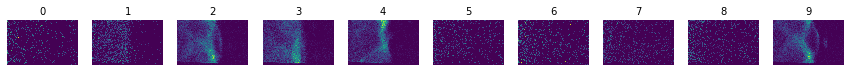

In [288]:
N = 10
fig, ax = plt.subplots(1,N,figsize=(15,5))
ix,iy = np.random.randint(0,axisData["dims"][0], N), np.random.randint(0, axisData["dims"][1], N)
print(list(zip(ix, iy)))
imgs = [xarr.isel(posx=i, posy=j).values for i,j in zip(ix,iy)]
for i,img in enumerate(imgs):
    # img = tr.pipe(cut.values,transform_nonoise).numpy()
    ax[i].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[i].set_title(f'{i}')
    ax[i].set_xlabel('ky')
    ax[i].set_ylabel('E')
    #turn off axis
    ax[i].axis('off')




In [289]:
# def makeBadNoiseMask(removed): #removed = procent af billedet der skal fjernes
#     if(removed != 0):
#         once = np.reshape(np.random.choice([0, 1], size=axisData['dims'][2]*axisData['dims'][3], p=[removed/100, (100-removed)/100]), axisData['dims'][2:])
#         return once, False
#     return None, True



def bad_noice(imgIn, removed, mask=None):
    # if(mask == None):
    #     mask = makeBadNoiseMask(removed)
    if(removed != 0):
        img = np.copy(imgIn)
        # s = img.shape
        # return img * np.reshape(np.random.choice([0, 1], size=s[0]*s[1], p=[removed/100, (100-removed)/100]), s)
        mean = 1 - removed/100
        n = int(img.size)
        # stddev = 0.3
        stddev = 0.3
        gauss = stats.truncnorm.rvs((0-mean)/stddev, (1-mean)/stddev,
                             loc = mean, scale = stddev,
                             size = n)
        gauss = np.reshape(gauss, img.shape)
        img *= gauss
        return img
    return imgIn



def entropy(img):
    n_clusters = np.max(img)+1
    t = dict([]*(n_clusters))
    bigSum = 0
    for clus in range(n_clusters):
        mask = np.where(img == clus, 1, 0)
        conv = sps.convolve(mask, np.ones((3,3)))
        s = np.sum(np.where(mask == 0, conv[1:-1, 1:-1], 0))

        try:
            s = s / (img.size - np.sum(mask))**(1/2)
        except: 
            s = 0

        t[f"{clus}"] = s
        bigSum += s
        # print(img.size)

    return bigSum, t

[(65, 35), (75, 2), (1, 61), (46, 30), (21, 60), (71, 45), (28, 21), (64, 4), (42, 24), (66, 52)]


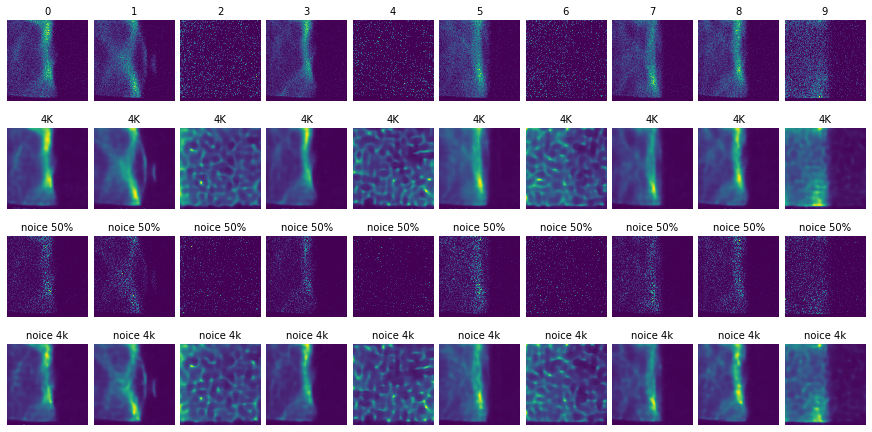

In [290]:
N=10
fig, ax = plt.subplots(4,N,figsize=(12,6),layout='constrained')

ix,iy = np.random.randint(0,axisData["dims"][0], N), np.random.randint(0, axisData["dims"][1], N)
imgs = [xarr.isel(posx=i, posy=j).values for i,j in zip(ix,iy)]
print(list(zip(ix, iy)))

for i,img in enumerate(imgs):
    img, rec = useARPES_on_img(img)

    ax[0,i].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[0,i].set_title(f'{i}')
    ax[0,i].axis('off')
    ax[1,i].imshow(rec, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[1,i].set_title(f'4K')
    ax[1,i].axis('off')

    noisyImg = bad_noice(img, 100)
    img, rec = useARPES_on_img(noisyImg)

    ax[2,i].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[2,i].set_title(f'noice 50%')
    ax[2,i].axis('off')
    ax[3,i].imshow(rec, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[3,i].set_title(f'noice 4k')
    ax[3,i].axis('off')


# prepare data for clustering

In [291]:
spectra = xarr.values.reshape((-1,axisData["dims"][3],axisData["dims"][2]))
data = {'raw':[], 'DCT32':[], '4k_En':[], '4k_De':[]}
times = {'raw':[], 'DCT32':[], '4k_En':[], '4k_De':[]}
for sp in tqdm(spectra):
    tsp, rec = useARPES_on_img(bad_noice(sp, 0), Numpy=False, decode=False)
    t0 = time.time()
    # data['raw'].append(sp.flatten())
    data['raw'].append(tsp.flatten().squeeze().detach().cpu().numpy())
    # times['raw'].append(time.time()-t0)

    t0=time.time()
    data['DCT32'].append(dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy())
    times['DCT32'].append(time.time()-t0)

    t0 = time.time()
    data["4k_En"].append(rec.flatten().squeeze().detach().cpu().numpy())
    times["4k_En"].append(time.time()-t0)

    t0 = time.time()
    data["4k_De"].append(decoder(rec).flatten().squeeze().detach().cpu().numpy())
    times["4k_De"].append(time.time()-t0)
data = {k:np.array(v) for k,v in data.items()}

  0%|          | 0/5229 [00:00<?, ?it/s]

In [292]:
# showCoord(imgs=[[data["raw"][getIndexFromCoord((6,8))].reshape((256, 256)), ""]])
# showCoord(imgs=[[data["raw"][getIndexFromCoord((4,3))].reshape((256, 256)), ""]])
# showCoord(imgs=[[data["raw"][getIndexFromCoord((8, 13))].reshape((256, 256)), ""]])
# showCoord(imgs=[[data["raw"][getIndexFromCoord((5, 13))].reshape((256, 256)), ""]])
# getIndexFromCoord((8,13))
# print(data["raw"])

In [293]:
for k in times.keys():
    t = times[k]
    d = data[k]
    print(f"{k:10s}: {np.sum(t):.2f}s | {d.shape}")

raw       : 0.00s | (5229, 65536)
DCT32     : 9.67s | (5229, 1024)
4k_En     : 0.15s | (5229, 512)
4k_De     : 20.13s | (5229, 65536)


# clustering

In [294]:
kres = {}
ktime = {}
kscore = {}
n_clusters = 4
init_idxs = skc.kmeans_plusplus(data["raw"], n_clusters, random_state=seed)[1]
for k,v in tqdm(data.items()):
    t0 = time.time()
    init_clusters = v[init_idxs]
    km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
    kres[k] = km.fit(v)
    ktime[k] = time.time()-t0
    kscore[k] = 0#skm.silhouette_score(v, kres[k].labels_)


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [295]:
print(filename + ":")
for k,v in data.items():
    compMask = kres[k].labels_
    # print(f"Score with {k} fit mask:")
    # s = skm.silhouette_score(data["raw"], compMask); print(f"raw data SC-score = {s}")
    # s = skm.silhouette_score(data["DCT32"], compMask); print(f"DCT32 data SC-score = {s}")
    # s = skm.silhouette_score(data["4k"], compMask); print(f"4k data SC-score = {s}")
    # print()
    # s = skm.calinski_harabasz_score(data["raw"], compMask); print(f"raw data CH-score = {s}")
    # s = skm.calinski_harabasz_score(data["DCT32"], compMask); print(f"DCT32 data CH-score = {s}")
    # s = skm.calinski_harabasz_score(data["4k"], compMask); print(f"4k data CH-score = {s}")
    # print()
    # s = skm.davies_bouldin_score(data["raw"], compMask); print(f"raw data DB-score = {s}")
    # s = skm.davies_bouldin_score(data["DCT32"], compMask); print(f"DCT32 data DB-score = {s}")
    # s = skm.davies_bouldin_score(data["4k_En"], compMask); print(f"4k data DB-score = {s}")
    # print("\n\n")
    s,_ = entropy(compMask.reshape(dimension_sizes[:2])); print(f"{k} data entropy-score = {s}")
    kscore[k] = s
    # print("\n")

GPScan_5.h5:
raw data entropy-score = 90.39532294245296
DCT32 data entropy-score = 99.85754365827664
4k_En data entropy-score = 89.24333692892733
4k_De data entropy-score = 90.17926099989756


In [296]:
# fig,ax = plt.subplots(1,len(data), figsize=(15,3))
# shape = tuple(axisData["dims"][:2])
# for i,(k,v) in enumerate(data.items()):
#     ax[i].imshow(v.reshape(shape),cmap='viridis',aspect='equal')
#     ax[i].set_title(f"{k}: {ktime[k]:.2f}s\nScore: {kscore[k]:.2f}")

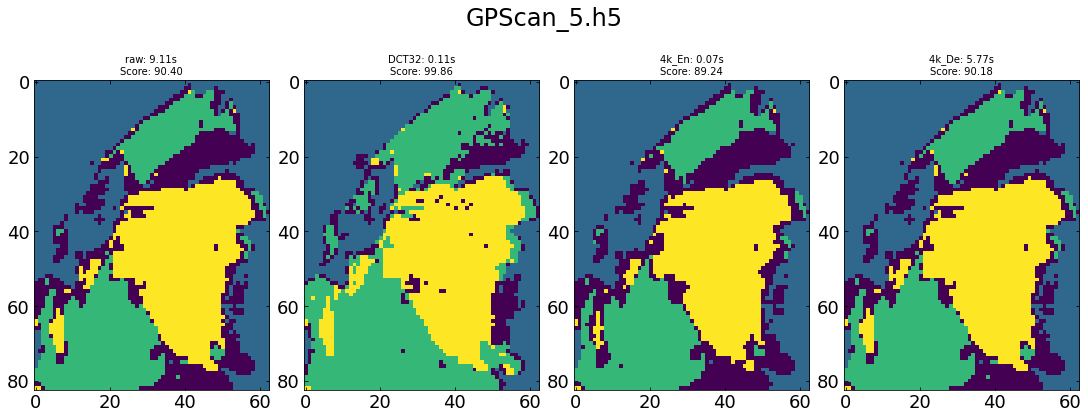

In [297]:
plt.rc("axes", labelsize=20, titlesize=10)   # skriftstørrelse af xlabel, ylabel og title
plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
plt.rcParams["font.size"] = "20"

fig,ax = plt.subplots(1,len(data), figsize=(15,6), layout='constrained')
fig.suptitle(f"{filename}")
shape = tuple(axisData["dims"][:2])
for i,(k,v) in enumerate(kres.items()):
    ax[i].imshow(v.labels_.reshape(shape),cmap='viridis',aspect='equal')
    ax[i].set_title(f"{k}: {ktime[k]:.2f}s\nScore: {kscore[k]:.2f}")

In [298]:
# fig, ax = plt.subplots(len(kres),n_clusters,figsize=(15,6))
# for i, (k, v) in enumerate(kres.items()):
#     centers = [np.mean(data['raw'][v.labels_==i],axis=0) for i in range(n_clusters)]
#     for j, c in enumerate(centers):
#         ax[i,j].imshow(c.reshape((256,256)),cmap='viridis',aspect='equal',origin='lower')
#         ax[i,j].axis('off')
#         ax[i,j].set_title(f"{k} {j}")



In [299]:
# border pre-selection

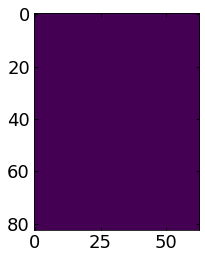

In [300]:
# print(int("s"))
n_mask_clusters = 1
km = skc.KMeans(n_clusters=n_mask_clusters)
filter_res = km.fit(data["4k_En"])
plt.figure()
plt.imshow(filter_res.labels_.reshape(shape), cmap='viridis', aspect='equal')
# print(list(filter_res.labels_.reshape(shape)))



In [301]:
# masked_spectra = xarr.values.reshape((-1,256,256))
# masked_spectra[filter_res.labels_.reshape(shape)==0] = np.zeros((256,256))
# print(int("s"))


In [302]:
filter_res.labels_.shape
spectra = xarr.values.reshape((-1,axisData["dims"][3],axisData["dims"][2]))
print(spectra.shape, filter_res.labels_.shape)

AOIMask = (filter_res.labels_[int(axisData["dims"][0]*axisData["dims"][1]/2) + int(axisData["dims"][0]/2)]+0)%n_mask_clusters
print(AOIMask)

(5229, 150, 240) (5229,)
0


Text(0, 0.5, '$E_{bin} - E_f$ [eV]')

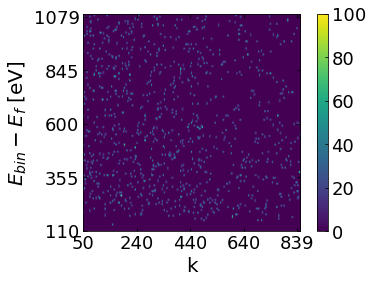

In [ ]:
plt.figure()
plt.imshow(data["raw"][1100].reshape(256, 256))#spectra[int(axisData["dims"][1]**2/2) + int(axisData["dims"][0]/2)],cmap='viridis',aspect='equal')
plt.colorbar()
xticks = list(range(0, 256, 63))
xticksL = ['50', "240", "440", "640", "839"]
yticks = list(range(0, 256, 63))
yticksL = ['110', "355", "600", "845", "1079"]

ax = plt.gca()
ax.set_xticks(xticks)
ax.set_xticklabels(xticksL)
ax.set_yticks(yticks)
ax.set_yticklabels(yticksL)
ax.invert_yaxis()
ax.set_xlabel("k")
ax.set_ylabel("$E_{bin} - E_f$ [eV]")

In [304]:
data2 = data.copy()

#Fjerner kanten
for nr, (sp, mask) in enumerate(tqdm(zip(spectra, filter_res.labels_))):
    if mask != (AOIMask+0)%n_mask_clusters:
        data2['raw'][nr] = np.zeros((256,256)).flatten()
        data2['DCT32'][nr] = np.zeros((1024)).flatten()
        data2["4k_En"][nr] = np.zeros((512)).flatten()
        data2["4k_De"][nr] = np.zeros((256,256)).flatten()


0it [00:00, ?it/s]

# cluster masked data

In [305]:
kres = {}
ktime = {}
kscore = {}
kscoreSample = {}
n_clusters = 4
for k,v in tqdm(data2.items()):
    if(True or k == "4k"):
        init_idxs = skc.kmeans_plusplus(v, n_clusters)[1]
        t0 = time.time()
        init_clusters = v[init_idxs]
        km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
        kres[k] = km.fit(v)
        ktime[k] = time.time()-t0
        # kscore[k] = skm.silhouette_score(v, kres[k].labels_)
        kscoreSample[k] = skm.silhouette_samples(v, kres[k].labels_)

print(kscore)

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


{}


raw:
score = 0.12585173547267914
actual mean = 0.12585180752772995
tid = 3.276397466659546

DCT32:
score = 0.4264076352119446
actual mean = 0.4264076394865175
tid = 0.07051444053649902

4k_En:
score = 0.34567540884017944
actual mean = 0.34567539129733216
tid = 0.0459287166595459

4k_De:
score = 0.45514488220214844
actual mean = 0.45514489132123737
tid = 3.9497060775756836



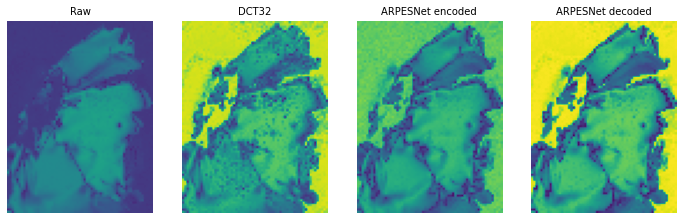

In [306]:
m = 1
for k, v in kscoreSample.items():
    mm = np.min(v)
    if(m >= mm): m = mm
for k, v in kscoreSample.items():
    kscore[k] = np.mean(kscoreSample[k])
    count = np.sum(np.where(v>0.95, 0, 1))
    mean = np.sum(v-1) / count + 1
    print(f"{k}:")
    print(f"score = {kscore[k]}")
    print(f"actual mean = {mean}")
    print(f"tid = {ktime[k]}\n")
    # kscoreSample[k] = np.where(v>0.7, m, v)
    # print(count)
    # kscoreSample[k] = np.where(v==0, 1, v)
# showCoord(imgs=[[np.reshape(v, shape), k] for k, v in kscoreSample.items()])
showCoord(imgs=[[np.reshape(kscoreSample["raw"], shape), "Raw"],
                [np.reshape(kscoreSample["DCT32"], shape), "DCT32"],
                [np.reshape(kscoreSample["4k_En"], shape), "ARPESNet encoded"],
                [np.reshape(kscoreSample["4k_De"], shape), "ARPESNet decoded"],
                ], clim=(kscoreSample["4k_De"].min(), kscoreSample["4k_De"].max()))

In [307]:
kres2 = {}
kres2["raw"] = kres["raw"].labels_
kres2["DCT32"] = sammeFarve(kres["raw"].labels_.reshape(shape), kres["DCT32"].labels_.reshape(shape))[1].flatten()
kres2["4k_En"] = sammeFarve(kres["raw"].labels_.reshape(shape), kres["4k_En"].labels_.reshape(shape))[1].flatten()
kres2["4k_De"] = sammeFarve(kres["raw"].labels_.reshape(shape), kres["4k_De"].labels_.reshape(shape))[1].flatten()

Samme farver: True
Samme farver: True
Samme farver: True


In [308]:
for k, v in kres2.items():
    print(f"Entropy = {entropy(v.reshape(shape))}")

Entropy = (72.39399026987289, {'0': 16.086693457006895, '1': 0.06915159710223878, '2': 34.70884384977203, '3': 21.529301365991735})
Entropy = (99.79590081079559, {'0': 18.546415702638622, '1': 21.311017289205324, '2': 30.147412067247863, '3': 29.791055751703762})
Entropy = (89.24333692892735, {'0': 12.635801810935225, '1': 40.811703465215544, '2': 14.680847288111542, '3': 21.114984364665037})
Entropy = (90.17926099989756, {'0': 39.28909831785925, '1': 13.873338673850949, '2': 15.201010955813299, '3': 21.81581305237406})


TypeError: 'AxesSubplot' object is not subscriptable

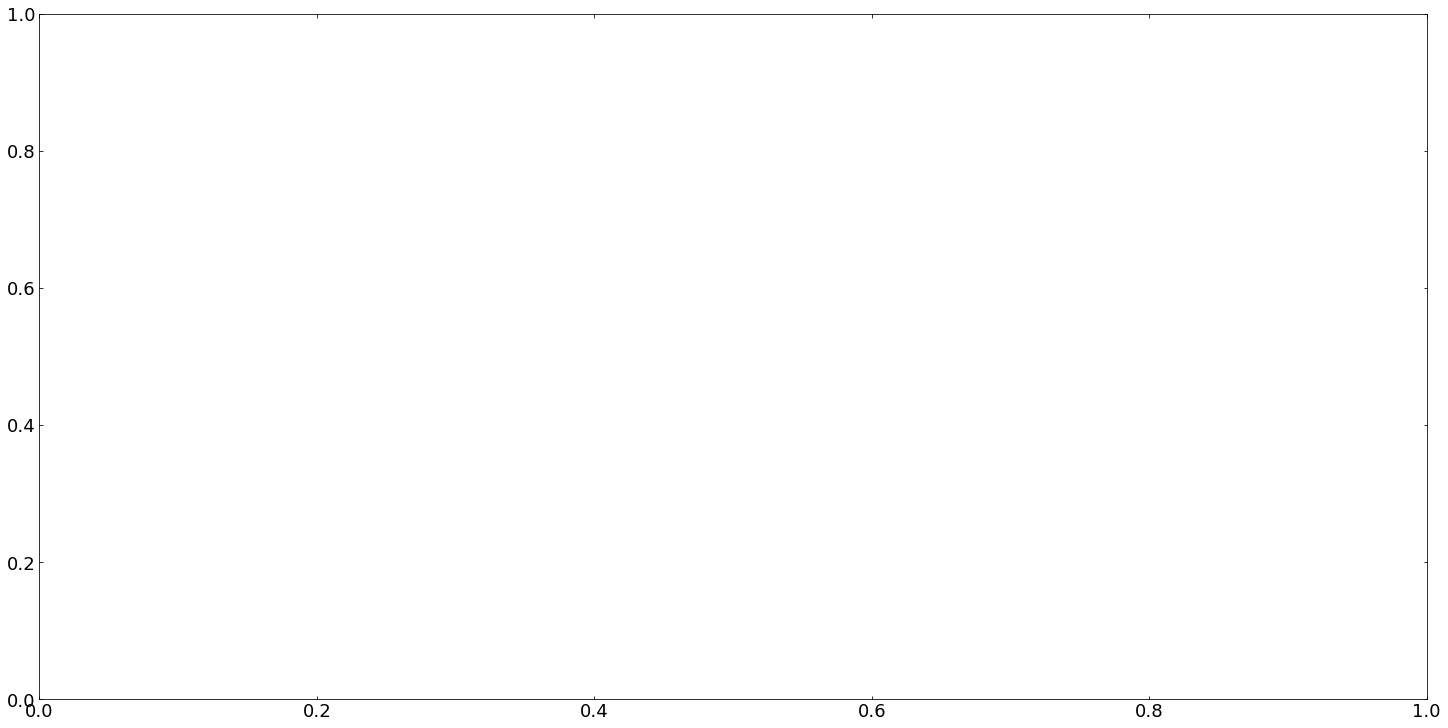

In [309]:
# fig,ax = plt.subplots(1,len(data.keys())+1, figsize=(20,10),layout='constrained')
fig,ax = plt.subplots(1,1, figsize=(20,10),layout='constrained')
shape = tuple(axisData["dims"][:2])
# selected = {k:v for k,v in kres2.items() if k not in ['simple','noise','denoiser']}
# for i_,(k,v) in enumerate(selected.items()):
#     i = i_ +1
#     img = v.reshape(shape).astype(float)
#     # img[img==0] = np.nan
#     ax[i].imshow(img,cmap='viridis',aspect='equal')#,origin='lower')
#     if k == '4k_En':
#         # ax[i].set_title(f"ARPESNet\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"ARPESNet encoded")
#     elif k == '4k_De':
#         # ax[i].set_title(f"ARPESNet decoded\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"ARPESNet decoded")
#     elif k == 'raw':
#         # ax[i].set_title(f"Raw\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"Raw")
#     else:
#         # ax[i].set_title(f"{k}\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"{k}")
#     ax[i].axis('off')
#     ax[i].text(30,3,f"({'abcdefghijklmnopq'[i]})",color='k',fontsize=12,ha='center', va='center')
imap = xarr.sum(['energy','angle'])
imap.values[filter_res.labels_.reshape(shape) != (AOIMask+0)%n_mask_clusters] = np.nan #edge filter
ax[0].imshow(imap.values,cmap='viridis',aspect='equal')#,origin='lower')
# imap.plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False)
ax[0].set_title('Intensitetskort')
plt.colorbar()
# ax[0].axis('off')
ax[0].text(30,3,f"(a)",color='k',fontsize=12,ha='center', va='center')
# fig.savefig('figs/fig7_panels.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')


TypeError: Invalid shape (65536,) for image data

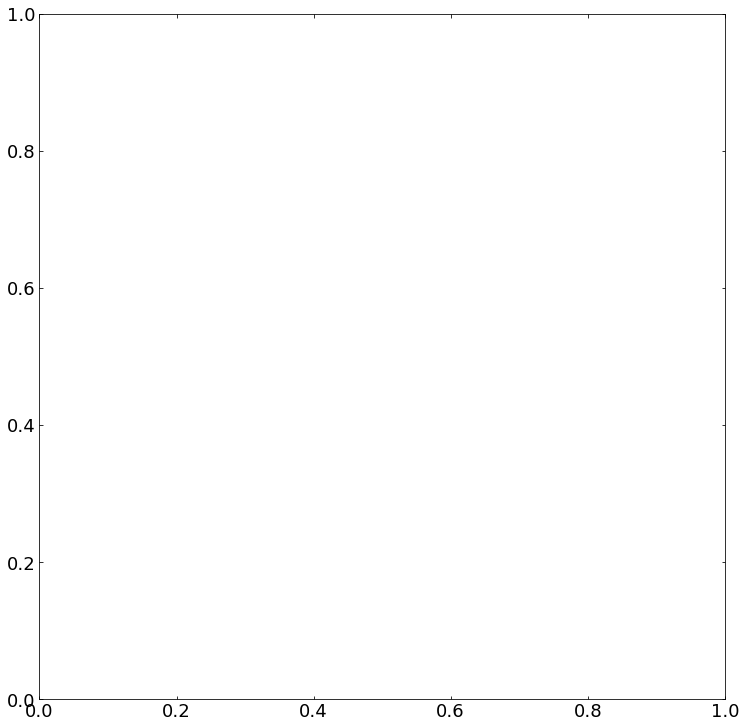

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(20,10),layout='constrained')
shape = tuple(axisData["dims"][:2])
# selected = {k:v for k,v in kres2.items() if k not in ['simple','noise','denoiser']}
# for i_,(k,v) in enumerate(selected.items()):
#     i = i_ +1
#     img = v.reshape(shape).astype(float)
#     # img[img==0] = np.nan
#     ax[i].imshow(img,cmap='viridis',aspect='equal')#,origin='lower')
#     if k == '4k_En':
#         # ax[i].set_title(f"ARPESNet\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"ARPESNet encoded")
#     elif k == '4k_De':
#         # ax[i].set_title(f"ARPESNet decoded\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"ARPESNet decoded")
#     elif k == 'raw':
#         # ax[i].set_title(f"Raw\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"Raw")
#     else:
#         # ax[i].set_title(f"{k}\nScore: {kscore[k]:.2f}")
#         ax[i].set_title(f"{k}")
#     ax[i].axis('off')
#     ax[i].text(30,3,f"({'abcdefghijklmnopq'[i]})",color='k',fontsize=12,ha='center', va='center')
imap = xarr.sum(['energy','angle'])
imap.values[filter_res.labels_.reshape(shape) != (AOIMask+0)%n_mask_clusters] = np.nan #edge filter
plt.imshow(data["raw"][76],cmap='viridis',aspect='equal')#,origin='lower')
# imap.plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False)
# ax.set_title('Intensitetskort')
plt.colorbar()
xticks = list(range(0, 14, 3))
yticks = list(range(0, 12, 3))
ax = plt.gca()
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax[0].axis('off')
# plt.text(30,3,f"(a)",color='k',fontsize=12,ha='center', va='center')
# fig.savefig('figs/fig7_panels.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')
# plt.savefig(r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\Figure\misfitHeat.png")


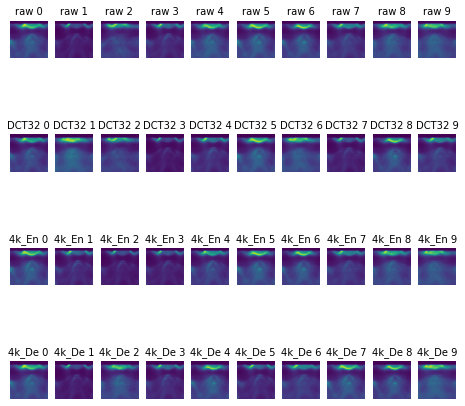

In [ ]:
fig, ax = plt.subplots(len(kres),n_clusters, figsize=(8,8))
for i, (k, v) in enumerate(kres.items()):
    centers = [np.mean(data2['raw'][v.labels_==i], axis=0) for i in range(n_clusters)]
    for j, c in enumerate(centers):
        ax[i,j].imshow(c.reshape((256,256)), cmap='viridis', aspect='equal', origin='lower')
        ax[i,j].axis('off')
        ax[i,j].set_title(f"{k} {j}")

In [ ]:
xarr.isel(
    posx=np.random.randint(0, axisData["dims"][0], 1), 
    posy=np.random.randint(0, axisData["dims"][1], 1),
).squeeze()

<xarray.DataArray (energy: 970, angle: 790)>
array([[12.80842686, 13.88355732, 15.63831139, ..., 10.86946011,
        10.99516106, 10.96265793],
       [15.81381226, 15.55376911, 14.29205418, ..., 10.27747917,
         9.99907494, 10.16703796],
       [17.88589859, 18.10382652, 16.36161232, ..., 11.45324707,
        10.07685947,  9.66681671],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.68106896],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.00168037]])
Coordinates:
    posx     int32 4
    posy     int32 8
  * angle    (angle) int32 0 1 2 3 4 5 6 7 8 ... 782 783 784 785 786 787 788 789
  * energy   (energy) int32 0 1 2 3 4 5 6 7 ... 962 963 964 965 966 967 968 969

[1] [2]


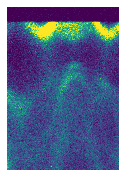

In [ ]:
N = 10
fig, ax = plt.subplots(1,1,figsize=(2,3))
x,y = np.random.randint(0, axisData["dims"][0], 1), np.random.randint(0, axisData["dims"][1], 1)
img = xarr.isel(posx=x, posy=y)
img -= img.min()
# img /= img.max()
img.squeeze().plot.imshow(ax=ax, cmap='viridis', robust=True, add_colorbar=False)
ax.set_title('')
ax.axis('off')
print(x,y)
# fig.savefig('figs/fig7_panel_a.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')



In [ ]:
# testImg = np.zeros((256, 256))
# testImg[125:129, 80:129] = 1

# img, rec = useARPES_on_img(testImg)

# showCoord(imgs=[[img, ""], [rec, ""]])